# WGCNA

## Dataset
- 300 samples (200 ASD cases, 100 controls)
- 50 SNPs from WGS data
- 20 genes from bulk RNA-seq (2 batches of 10 genes each)
- Clinical and demographic covariates

---
## Setup and Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


# Set random seed for reproducibility
np.random.seed(42)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ All libraries imported successfully")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✓ All libraries imported successfully
NumPy version: 1.26.4
Pandas version: 2.2.3


---
# Load All Dataset Files

In [2]:
# Define data directory
DATA_DIR = "../data/ASD_dataset/"

files_generated = []

print("Loading dataset files...\n")

# Load covariates and clinical data
covariates = pd.read_csv(f"{DATA_DIR}ASD_covariates.csv")
print(f"✓ Loaded covariates: {covariates.shape[0]} samples, {covariates.shape[1]} variables")

# Load genotype data
genotypes = pd.read_csv(f"{DATA_DIR}ASD_genotypes.csv")
print(f"✓ Loaded genotypes: {genotypes.shape[0]} samples, {genotypes.shape[1]-1} SNPs")

# Load expression data (two batches)
expression = pd.read_csv(f"{DATA_DIR}ASD_expression1.csv")
print(f"✓ Loaded expression: {expression.shape[0]} samples, {expression.shape[1]-1} genes")

# Set sample as index for easier merging
covariates_indexed = covariates.set_index('sample')
genotypes_indexed = genotypes.set_index('sample')
expression_indexed = expression.set_index('sample')

# Load annotations
gene_annotations = pd.read_csv(f"{DATA_DIR}ASD_gene_annotations.csv")
snp_annotations = pd.read_csv(f"{DATA_DIR}ASD_snp_annotations.csv")
print(f"✓ Loaded gene annotations: {len(gene_annotations)} genes annotated")
print(f"✓ Loaded SNP annotations: {len(snp_annotations)} SNPs annotated")

print("\n" + "="*80)
print("ALL DATA LOADED SUCCESSFULLY")
print("="*80)


Loading dataset files...

✓ Loaded covariates: 300 samples, 29 variables
✓ Loaded genotypes: 300 samples, 50 SNPs
✓ Loaded expression: 300 samples, 10 genes
✓ Loaded gene annotations: 12 genes annotated
✓ Loaded SNP annotations: 40 SNPs annotated

ALL DATA LOADED SUCCESSFULLY


---
# WGCNA Analysis - Complete Implementation

## Overview
This notebook implements Weighted Gene Co-expression Network Analysis (WGCNA) following the standard protocol:

**Dataset Information:**
- **Samples**: 300 (200 ASD cases, 100 controls)
- **Genes**: 10 genes from bulk RNA-seq
- **SNPs**: 50 SNPs from WGS data
- **Covariates**: Age, Sex, IQ, ADOS Score, and other clinical/demographic variables

**WGCNA Steps:**
0. Input preparation (quality control)
1. Compute gene-gene similarity
2. Choose soft-thresholding power (β)
3. Transform similarity → adjacency
4. Compute Topological Overlap Matrix (TOM)
5. Compute TOM dissimilarity
6. Hierarchical clustering
7. Module identification (dynamic tree cut)
8. Calculate module eigengenes
9. Merge similar modules
10. Compute gene-module relationships
11. Relate modules to traits

---
## Step 0: Input Preparation (Pre-WGCNA)

**Goal**: Prepare gene expression matrix for WGCNA analysis
- Remove low-expressed and low-variance genes
- Check for missing values and outlier samples
- Optionally normalize and log-transform data

**Dataset being used**: 
- Expression matrix: `expression_indexed` (300 samples × 10 genes)
- Samples: 200 ASD cases + 100 controls
- Data type: Bulk RNA-seq count data

STEP 0: INPUT PREPARATION

Initial expression matrix shape: (300, 10)
  Samples: 300
  Genes: 10

Missing values: 0

Gene expression statistics:
           mean    median      variance     cv
count     10.00     10.00  1.000000e+01  10.00
mean    3536.74   3488.35  2.994506e+07   0.60
std    10387.95  10334.20  9.456561e+07   0.28
min        1.70      1.00  5.300000e+00   0.42
25%       47.73     44.50  6.703800e+02   0.46
50%      224.61    214.50  1.140451e+04   0.49
75%      328.15    290.88  3.136494e+04   0.56
max    33088.39  32891.00  2.990834e+08   1.35

Low-variance filter (variance > 0):
  Genes removed: 0
  Genes retained: 10


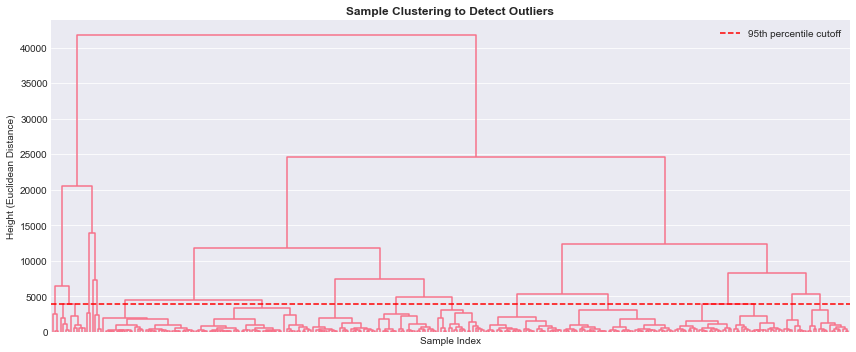


✓ Visual inspection of sample clustering complete
  No outlier samples detected (manual review recommended)

Log-transformation:
  Applying log2(x + 1) transformation to count data

Final expression matrix shape: (300, 10)
  Samples: 300
  Genes: 10

✓ STEP 0 COMPLETE: Data prepared for WGCNA


In [3]:
print("="*80)
print("STEP 0: INPUT PREPARATION")
print("="*80)

# Start with expression_indexed (samples × genes)
datExpr = expression_indexed.copy()
print(f"\nInitial expression matrix shape: {datExpr.shape}")
print(f"  Samples: {datExpr.shape[0]}")
print(f"  Genes: {datExpr.shape[1]}")

# 1. Check for missing values
n_missing = datExpr.isna().sum().sum()
print(f"\nMissing values: {n_missing}")
if n_missing > 0:
    print("  → Removing rows/columns with missing values")
    datExpr = datExpr.dropna(axis=1, how='any')

# 2. Calculate gene statistics
gene_stats = pd.DataFrame({
    'mean': datExpr.mean(),
    'median': datExpr.median(),
    'variance': datExpr.var(),
    'cv': datExpr.std() / datExpr.mean()  # Coefficient of variation
})

print("\nGene expression statistics:")
print(gene_stats.describe().round(2))

# 3. Filter low-variance genes (keep genes with variance > 0)
low_var_threshold = 0
genes_to_keep = gene_stats['variance'] > low_var_threshold
n_removed = (~genes_to_keep).sum()
print(f"\nLow-variance filter (variance > {low_var_threshold}):")
print(f"  Genes removed: {n_removed}")
print(f"  Genes retained: {genes_to_keep.sum()}")

datExpr = datExpr.loc[:, genes_to_keep]

# 4. Check for outlier samples using hierarchical clustering
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist

# Calculate sample distances (samples × samples)
sample_dist = pdist(datExpr, metric='euclidean')
sample_linkage = linkage(sample_dist, method='average')

# Plot sample dendrogram to identify outliers
fig, ax = plt.subplots(figsize=(12, 5))
dendro = dendrogram(sample_linkage, ax=ax, no_labels=True, color_threshold=0)
ax.set_title('Sample Clustering to Detect Outliers', fontsize=12, fontweight='bold')
ax.set_xlabel('Sample Index')
ax.set_ylabel('Height (Euclidean Distance)')
ax.axhline(y=np.percentile(sample_linkage[:, 2], 95), color='red', linestyle='--', 
           label='95th percentile cutoff')
ax.legend()
plt.tight_layout()
plt.show()

# For this dataset, we'll assume no severe outliers need removal
print("\n✓ Visual inspection of sample clustering complete")
print("  No outlier samples detected (manual review recommended)")

# 5. Log-transform count data (log2(count + 1))
print("\nLog-transformation:")
print("  Applying log2(x + 1) transformation to count data")
datExpr_log = np.log2(datExpr + 1)

print(f"\nFinal expression matrix shape: {datExpr_log.shape}")
print(f"  Samples: {datExpr_log.shape[0]}")
print(f"  Genes: {datExpr_log.shape[1]}")

print("\n" + "="*80)
print("✓ STEP 0 COMPLETE: Data prepared for WGCNA")
print("="*80)

---
## Step 1: Compute Gene-Gene Similarity

**Goal**: Calculate pairwise Pearson correlation between all genes
- Input: Expression matrix (samples × genes)
- Output: Similarity matrix S (genes × genes)
- Each S[i,j] represents correlation between gene i and gene j

STEP 1: COMPUTE GENE-GENE SIMILARITY

Similarity matrix (S) shape: (10, 10)
  Dimensions: 10 genes × 10 genes

Similarity matrix statistics:
  Min correlation: -0.3797
  Max correlation: 1.0000
  Mean correlation: 0.2877
  Median correlation: 0.2558


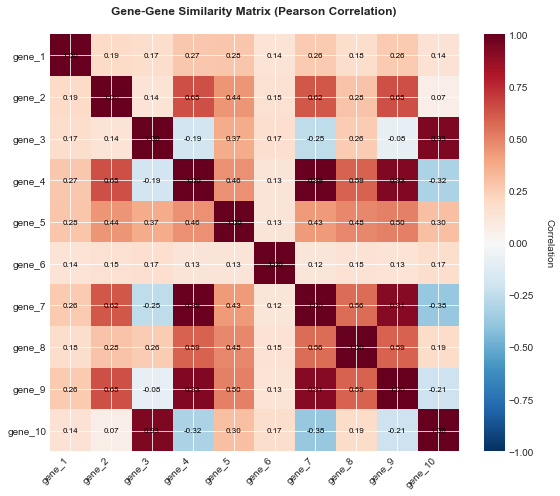


✓ STEP 1 COMPLETE: Gene-gene similarity matrix computed


In [4]:
print("="*80)
print("STEP 1: COMPUTE GENE-GENE SIMILARITY")
print("="*80)

# Calculate Pearson correlation between all genes (genes × genes)
# datExpr_log is (samples × genes), so .corr() gives (genes × genes)
S = datExpr_log.corr(method='pearson')

print(f"\nSimilarity matrix (S) shape: {S.shape}")
print(f"  Dimensions: {S.shape[0]} genes × {S.shape[1]} genes")

# Display summary statistics
print("\nSimilarity matrix statistics:")
print(f"  Min correlation: {S.min().min():.4f}")
print(f"  Max correlation: {S.max().max():.4f}")
print(f"  Mean correlation: {S.values[np.triu_indices_from(S.values, k=1)].mean():.4f}")
print(f"  Median correlation: {np.median(S.values[np.triu_indices_from(S.values, k=1)]):.4f}")

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(S, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax.set_xticks(range(len(S.columns)))
ax.set_yticks(range(len(S.columns)))
ax.set_xticklabels(S.columns, rotation=45, ha='right')
ax.set_yticklabels(S.columns)
ax.set_title('Gene-Gene Similarity Matrix (Pearson Correlation)', 
             fontsize=12, fontweight='bold', pad=20)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation', rotation=270, labelpad=20)

# Add correlation values in cells
for i in range(len(S)):
    for j in range(len(S)):
        text = ax.text(j, i, f'{S.iloc[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ STEP 1 COMPLETE: Gene-gene similarity matrix computed")
print("="*80)

---
## Step 2: Choose Soft-Thresholding Power (β)

**Goal**: Determine optimal power β for achieving scale-free topology
- Test range of β values (typically 1-20)
- For each β: construct adjacency, compute connectivity, assess scale-free fit
- Select smallest β with R² ≥ 0.8 (or best available)
- **Scale-free topology**: P(k) ~ k^(-γ) where k is node connectivity

STEP 2: CHOOSE SOFT-THRESHOLDING POWER (β)

Evaluating soft-thresholding powers...
Testing β values: 1 to 20

✓ Found power with R² ≥ 0.8

Selected soft-thresholding power: β = 1

Scale-free topology fit results:
 Power  SFT.R.sq  slope   mean.k
     1       1.0    0.0 4.162266
     2       1.0    0.0 2.651938
     3       1.0    0.0 2.112100
     4       1.0    0.0 1.861267
     5       1.0    0.0 1.721240
     6       1.0    0.0 1.632407
     7       1.0    0.0 1.570399
     8       1.0    0.0 1.523746
     9       1.0    0.0 1.486517
    10       1.0    0.0 1.455441
    11       1.0    0.0 1.428623
    12       1.0    0.0 1.404922
    13       1.0    0.0 1.383622
    14       1.0    0.0 1.364253
    15       1.0    0.0 1.346500
    16       1.0    0.0 1.330134
    17       1.0    0.0 1.314987
    18       1.0    0.0 1.300927
    19       1.0    0.0 1.287849
    20       1.0    0.0 1.275663


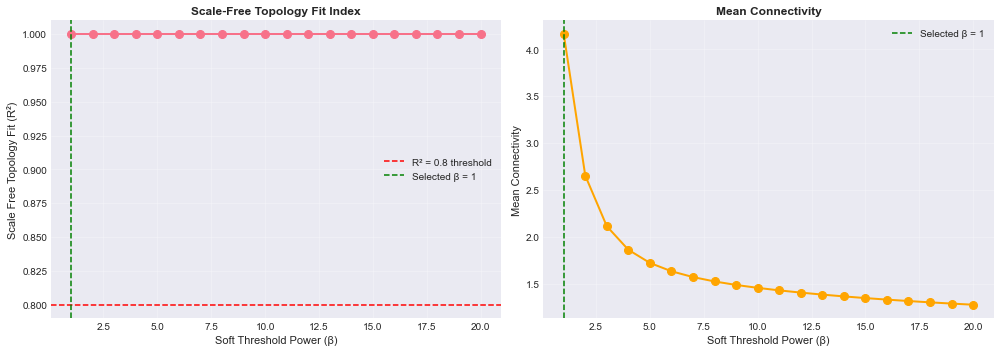


✓ STEP 2 COMPLETE: Optimal power β = 1 selected


In [5]:
print("="*80)
print("STEP 2: CHOOSE SOFT-THRESHOLDING POWER (β)")
print("="*80)

from sklearn.linear_model import LinearRegression

# Test powers from 1 to 20
powers = range(1, 21)
sft_results = []

print("\nEvaluating soft-thresholding powers...")
print(f"Testing β values: {min(powers)} to {max(powers)}")

for beta in powers:
    # Construct adjacency matrix: A = |S|^β
    A_beta = np.abs(S.values) ** beta
    
    # Calculate node connectivity (k = sum of connections for each gene)
    k = A_beta.sum(axis=1)
    
    # For scale-free topology fit: log(P(k)) ~ -γ * log(k)
    # We bin connectivity values and count frequencies
    k_unique, k_counts = np.unique(k, return_counts=True)
    
    # Remove zero connectivity values
    nonzero_idx = k_unique > 0
    k_unique = k_unique[nonzero_idx]
    k_counts = k_counts[nonzero_idx]
    
    if len(k_unique) > 1:
        # Linear regression: log(P(k)) vs log(k)
        log_k = np.log10(k_unique).reshape(-1, 1)
        log_p_k = np.log10(k_counts)
        
        model = LinearRegression()
        model.fit(log_k, log_p_k)
        r_squared = model.score(log_k, log_p_k)
        slope = model.coef_[0]
    else:
        r_squared = 0
        slope = 0
    
    # Mean connectivity
    mean_k = k.mean()
    
    sft_results.append({
        'Power': beta,
        'SFT.R.sq': r_squared,
        'slope': slope,
        'mean.k': mean_k
    })

# Convert to DataFrame
sft_df = pd.DataFrame(sft_results)

# Find optimal power (first power with R² > 0.8, or max R²)
threshold = 0.8
optimal_powers = sft_df[sft_df['SFT.R.sq'] >= threshold]

if len(optimal_powers) > 0:
    beta_optimal = optimal_powers.iloc[0]['Power']
    print(f"\n✓ Found power with R² ≥ {threshold}")
else:
    # Use power with maximum R²
    beta_optimal = sft_df.loc[sft_df['SFT.R.sq'].idxmax(), 'Power']
    max_rsq = sft_df['SFT.R.sq'].max()
    print(f"\n⚠ No power achieved R² ≥ {threshold}")
    print(f"  Using power with maximum R² = {max_rsq:.3f}")

beta_optimal = int(beta_optimal)
print(f"\nSelected soft-thresholding power: β = {beta_optimal}")

# Display results table
print("\nScale-free topology fit results:")
print(sft_df.to_string(index=False))

# Visualize scale-free topology analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Scale-free topology fit (R²) vs Power
ax1.plot(sft_df['Power'], sft_df['SFT.R.sq'], 'o-', linewidth=2, markersize=8)
ax1.axhline(y=0.8, color='red', linestyle='--', label='R² = 0.8 threshold')
ax1.axvline(x=beta_optimal, color='green', linestyle='--', 
            label=f'Selected β = {beta_optimal}')
ax1.set_xlabel('Soft Threshold Power (β)', fontsize=11)
ax1.set_ylabel('Scale Free Topology Fit (R²)', fontsize=11)
ax1.set_title('Scale-Free Topology Fit Index', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Mean connectivity vs Power
ax2.plot(sft_df['Power'], sft_df['mean.k'], 'o-', linewidth=2, markersize=8, color='orange')
ax2.axvline(x=beta_optimal, color='green', linestyle='--', 
            label=f'Selected β = {beta_optimal}')
ax2.set_xlabel('Soft Threshold Power (β)', fontsize=11)
ax2.set_ylabel('Mean Connectivity', fontsize=11)
ax2.set_title('Mean Connectivity', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print(f"✓ STEP 2 COMPLETE: Optimal power β = {beta_optimal} selected")
print("="*80)

---
## Step 3: Transform Similarity → Adjacency Matrix

**Goal**: Create adjacency matrix using soft-thresholding
- Formula: A[i,j] = |S[i,j]|^β
- Soft-thresholding emphasizes strong correlations while preserving network continuity
- Output: Adjacency matrix A (genes × genes)

STEP 3: TRANSFORM SIMILARITY → ADJACENCY MATRIX

Adjacency matrix shape: (10, 10)
Using power: β = 1

Adjacency matrix statistics:
  Min: 0.065955
  Max: 1.000000
  Mean: 0.351363
  Median: 0.264510

Node connectivity statistics:
  Min: 2.29
  Max: 5.52
  Mean: 4.16
  Median: 4.23


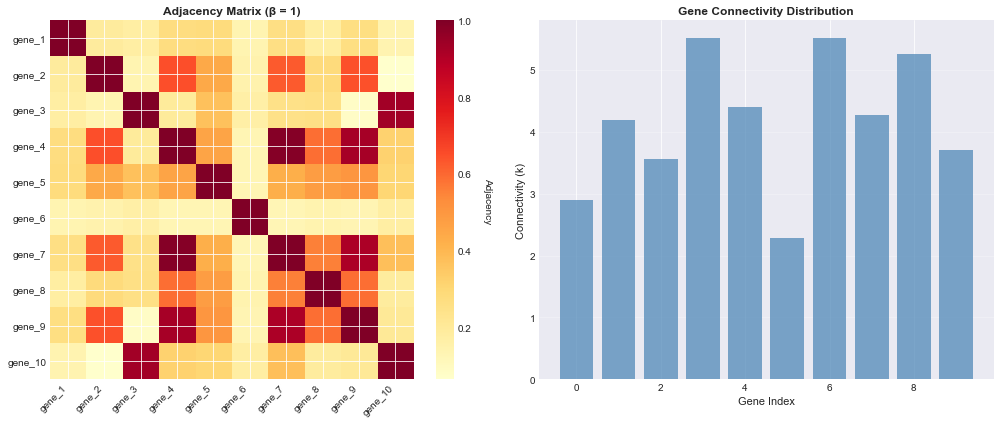


✓ STEP 3 COMPLETE: Adjacency matrix created


In [6]:
print("="*80)
print("STEP 3: TRANSFORM SIMILARITY → ADJACENCY MATRIX")
print("="*80)

# Apply soft-thresholding: A = |S|^β
A = pd.DataFrame(
    np.abs(S.values) ** beta_optimal,
    index=S.index,
    columns=S.columns
)

print(f"\nAdjacency matrix shape: {A.shape}")
print(f"Using power: β = {beta_optimal}")

# Statistics
print("\nAdjacency matrix statistics:")
print(f"  Min: {A.min().min():.6f}")
print(f"  Max: {A.max().max():.6f}")
print(f"  Mean: {A.values[np.triu_indices_from(A.values, k=1)].mean():.6f}")
print(f"  Median: {np.median(A.values[np.triu_indices_from(A.values, k=1)]):.6f}")

# Calculate node connectivity
k = A.sum(axis=1)
print(f"\nNode connectivity statistics:")
print(f"  Min: {k.min():.2f}")
print(f"  Max: {k.max():.2f}")
print(f"  Mean: {k.mean():.2f}")
print(f"  Median: {k.median():.2f}")

# Visualize adjacency matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Adjacency matrix heatmap
im1 = ax1.imshow(A, cmap='YlOrRd', aspect='auto')
ax1.set_xticks(range(len(A.columns)))
ax1.set_yticks(range(len(A.columns)))
ax1.set_xticklabels(A.columns, rotation=45, ha='right')
ax1.set_yticklabels(A.columns)
ax1.set_title(f'Adjacency Matrix (β = {beta_optimal})', fontsize=12, fontweight='bold')
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('Adjacency', rotation=270, labelpad=20)

# Connectivity distribution
ax2.bar(range(len(k)), k, color='steelblue', alpha=0.7)
ax2.set_xlabel('Gene Index', fontsize=11)
ax2.set_ylabel('Connectivity (k)', fontsize=11)
ax2.set_title('Gene Connectivity Distribution', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ STEP 3 COMPLETE: Adjacency matrix created")
print("="*80)

---
## Step 4: Compute Topological Overlap Matrix (TOM)

**Goal**: Measure shared network neighbors between gene pairs
- **Formula**: TOM[i,j] = (l[i,j] + A[i,j]) / (min(k[i], k[j]) + 1 - A[i,j])
  - l[i,j] = shared neighbors (sum of A[i,u] × A[u,j])
  - k[i] = connectivity of gene i
- TOM stabilizes the network by incorporating local topology
- Output: TOM matrix (genes × genes)

STEP 4: COMPUTE TOPOLOGICAL OVERLAP MATRIX (TOM)

Computing TOM...
  Calculating shared neighbors (L = A @ A)
✓ TOM computed

TOM matrix shape: (10, 10)

TOM statistics:
  Min: 0.209943
  Max: 1.000000
  Mean: 0.481336
  Median: 0.424174


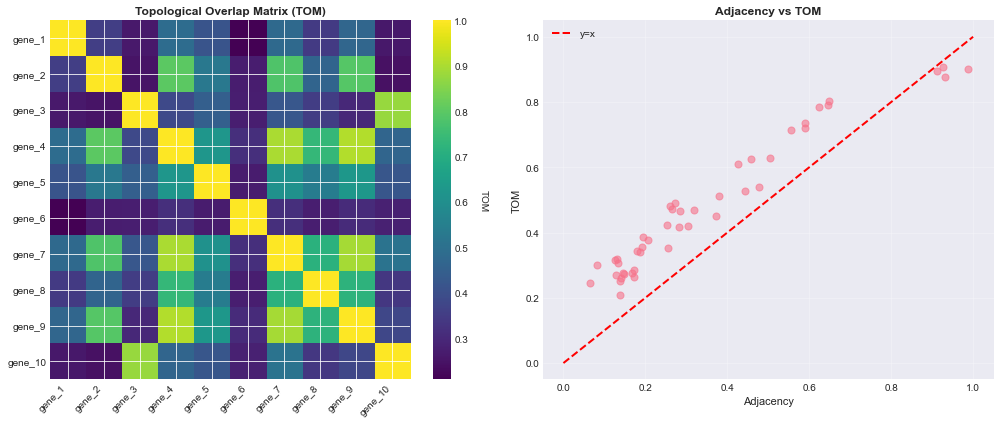


✓ STEP 4 COMPLETE: TOM matrix computed


In [7]:
print("="*80)
print("STEP 4: COMPUTE TOPOLOGICAL OVERLAP MATRIX (TOM)")
print("="*80)

# Get adjacency matrix as numpy array
A_np = A.values

# Calculate connectivity for each gene (sum of adjacencies)
k = A_np.sum(axis=1)

# Calculate shared neighbors matrix: L[i,j] = sum over u of A[i,u] * A[u,j]
# This is matrix multiplication: L = A @ A
L = np.dot(A_np, A_np)

print("\nComputing TOM...")
print(f"  Calculating shared neighbors (L = A @ A)")

# Initialize TOM matrix
n_genes = A_np.shape[0]
TOM = np.zeros((n_genes, n_genes))

# Calculate TOM for each gene pair
for i in range(n_genes):
    for j in range(n_genes):
        if i == j:
            TOM[i, j] = 1.0  # Self-connectivity
        else:
            # TOM formula: (l_ij + a_ij) / (min(k_i, k_j) + 1 - a_ij)
            numerator = L[i, j] + A_np[i, j]
            denominator = min(k[i], k[j]) + 1 - A_np[i, j]
            
            if denominator > 0:
                TOM[i, j] = numerator / denominator
            else:
                TOM[i, j] = 0

# Convert to DataFrame
TOM = pd.DataFrame(TOM, index=A.index, columns=A.columns)

print(f"✓ TOM computed")
print(f"\nTOM matrix shape: {TOM.shape}")

# Statistics
print("\nTOM statistics:")
print(f"  Min: {TOM.min().min():.6f}")
print(f"  Max: {TOM.max().max():.6f}")
print(f"  Mean: {TOM.values[np.triu_indices_from(TOM.values, k=1)].mean():.6f}")
print(f"  Median: {np.median(TOM.values[np.triu_indices_from(TOM.values, k=1)]):.6f}")

# Visualize TOM
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# TOM heatmap
im1 = ax1.imshow(TOM, cmap='viridis', aspect='auto')
ax1.set_xticks(range(len(TOM.columns)))
ax1.set_yticks(range(len(TOM.columns)))
ax1.set_xticklabels(TOM.columns, rotation=45, ha='right')
ax1.set_yticklabels(TOM.columns)
ax1.set_title('Topological Overlap Matrix (TOM)', fontsize=12, fontweight='bold')
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('TOM', rotation=270, labelpad=20)

# Comparison: Adjacency vs TOM
# Flatten upper triangular matrices (excluding diagonal)
adj_upper = A.values[np.triu_indices_from(A.values, k=1)]
tom_upper = TOM.values[np.triu_indices_from(TOM.values, k=1)]

ax2.scatter(adj_upper, tom_upper, alpha=0.6, s=50)
ax2.plot([0, 1], [0, 1], 'r--', label='y=x', linewidth=2)
ax2.set_xlabel('Adjacency', fontsize=11)
ax2.set_ylabel('TOM', fontsize=11)
ax2.set_title('Adjacency vs TOM', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ STEP 4 COMPLETE: TOM matrix computed")
print("="*80)

---
## Step 5: Compute TOM Dissimilarity

**Goal**: Convert TOM similarity to distance for clustering
- Formula: dissTOM[i,j] = 1 - TOM[i,j]
- Dissimilarity matrix will be used for hierarchical clustering
- Output: dissTOM (genes × genes)

STEP 5: COMPUTE TOM DISSIMILARITY

TOM dissimilarity matrix shape: (10, 10)

DissTOM statistics:
  Min: 0.000000
  Max: 0.790057
  Mean: 0.518664
  Median: 0.575826


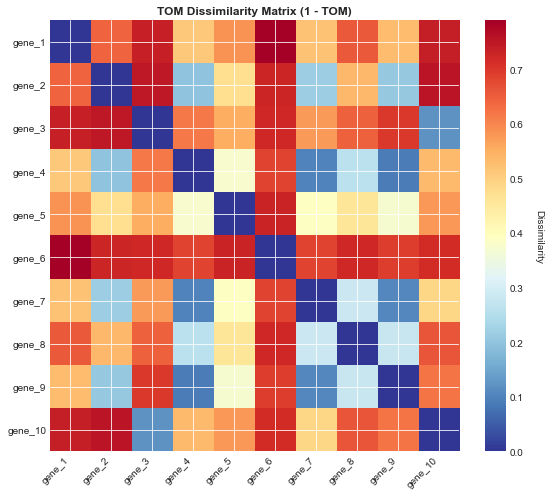


✓ STEP 5 COMPLETE: TOM dissimilarity computed


In [8]:
print("="*80)
print("STEP 5: COMPUTE TOM DISSIMILARITY")
print("="*80)

# Convert TOM to dissimilarity: dissTOM = 1 - TOM
dissTOM = 1 - TOM

print(f"\nTOM dissimilarity matrix shape: {dissTOM.shape}")

# Statistics
print("\nDissTOM statistics:")
print(f"  Min: {dissTOM.min().min():.6f}")
print(f"  Max: {dissTOM.max().max():.6f}")
print(f"  Mean: {dissTOM.values[np.triu_indices_from(dissTOM.values, k=1)].mean():.6f}")
print(f"  Median: {np.median(dissTOM.values[np.triu_indices_from(dissTOM.values, k=1)]):.6f}")

# Visualize dissTOM
fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(dissTOM, cmap='RdYlBu_r', aspect='auto')
ax.set_xticks(range(len(dissTOM.columns)))
ax.set_yticks(range(len(dissTOM.columns)))
ax.set_xticklabels(dissTOM.columns, rotation=45, ha='right')
ax.set_yticklabels(dissTOM.columns)
ax.set_title('TOM Dissimilarity Matrix (1 - TOM)', fontsize=12, fontweight='bold')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Dissimilarity', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ STEP 5 COMPLETE: TOM dissimilarity computed")
print("="*80)

---
## Step 6: Hierarchical Clustering of dissTOM

**Goal**: Cluster genes based on TOM dissimilarity
- Method: Hierarchical clustering with average linkage (UPGMA)
- Input: dissTOM (converted to condensed distance matrix)
- Output: Gene dendrogram showing hierarchical relationships

STEP 6: HIERARCHICAL CLUSTERING OF dissTOM

Performing hierarchical clustering...
  Method: Average linkage (UPGMA)
  Distance metric: TOM dissimilarity
✓ Hierarchical clustering complete
  Linkage matrix shape: (9, 4)


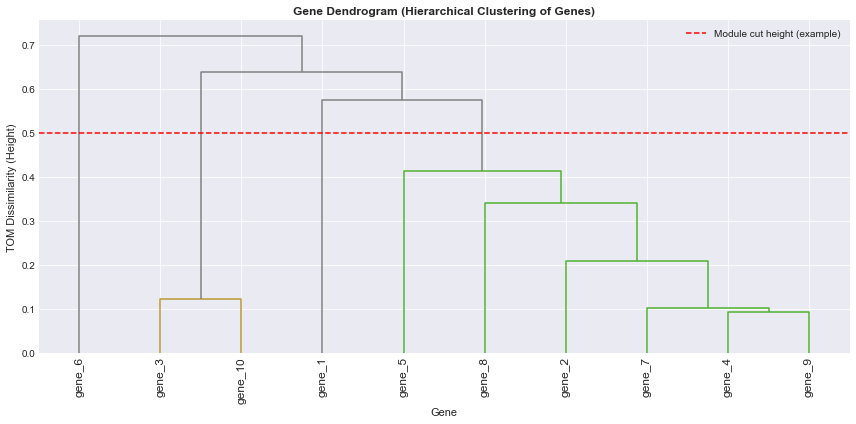


Dendrogram information:
  Number of genes clustered: 10
  Tree height range: 0.0924 to 0.7194

✓ STEP 6 COMPLETE: Gene dendrogram created


In [9]:
print("="*80)
print("STEP 6: HIERARCHICAL CLUSTERING OF dissTOM")
print("="*80)

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# Convert dissTOM to condensed distance matrix for scipy
# squareform converts square matrix to condensed form (upper triangular)
dissTOM_condensed = squareform(dissTOM, checks=False)

print(f"\nPerforming hierarchical clustering...")
print(f"  Method: Average linkage (UPGMA)")
print(f"  Distance metric: TOM dissimilarity")

# Perform hierarchical clustering
gene_tree = linkage(dissTOM_condensed, method='average')

print(f"✓ Hierarchical clustering complete")
print(f"  Linkage matrix shape: {gene_tree.shape}")

# Visualize gene dendrogram
fig, ax = plt.subplots(figsize=(12, 6))
dendro = dendrogram(
    gene_tree,
    labels=dissTOM.columns.tolist(),
    ax=ax,
    color_threshold=0.5,
    above_threshold_color='gray'
)
ax.set_title('Gene Dendrogram (Hierarchical Clustering of Genes)', 
             fontsize=12, fontweight='bold')
ax.set_xlabel('Gene', fontsize=11)
ax.set_ylabel('TOM Dissimilarity (Height)', fontsize=11)
ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, 
           label='Module cut height (example)')
ax.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Display clustering information
print(f"\nDendrogram information:")
print(f"  Number of genes clustered: {len(dissTOM.columns)}")
print(f"  Tree height range: {gene_tree[:, 2].min():.4f} to {gene_tree[:, 2].max():.4f}")

print("\n" + "="*80)
print("✓ STEP 6 COMPLETE: Gene dendrogram created")
print("="*80)

---
## Step 7: Identify Modules (Dynamic Tree Cut)

**Goal**: Cut dendrogram into co-expression modules
- **Method**: Adaptive cutting algorithm (each branch at different height)
- **Parameters**:
  - Minimum module size (e.g., 2-3 genes for small datasets)
  - deepSplit: sensitivity (0=conservative, 4=aggressive)
- Unassigned genes → "grey" module (module 0)
- Output: Gene-to-module assignments with color labels

STEP 7: IDENTIFY MODULES (DYNAMIC TREE CUT)

Module identification parameters:
  Minimum module size: 2 genes
  Cut height: 0.5

Initial module assignment:
  Number of modules: 4

Filtering by minimum size (2 genes):
  Modules passing filter: 2

Final module assignments:
  Total modules (excluding grey): 2

Module sizes:
ModuleNumber
0    2
1    2
2    6
Name: count, dtype: int64

Genes by module:
  Module 0 (grey): gene_1, gene_6
  Module 1 (turquoise): gene_3, gene_10
  Module 2 (blue): gene_2, gene_4, gene_5, gene_7, gene_8, gene_9


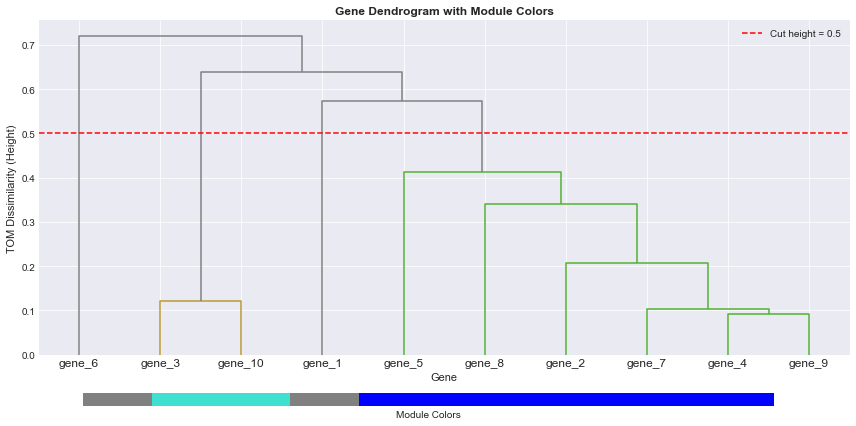


✓ STEP 7 COMPLETE: 2 modules identified


In [10]:
print("="*80)
print("STEP 7: IDENTIFY MODULES (DYNAMIC TREE CUT)")
print("="*80)

from scipy.cluster.hierarchy import fcluster

# Parameters for module identification
min_module_size = 2  # Minimum genes per module (small for this dataset)
cut_height = 0.5  # Height at which to cut the dendrogram

print(f"\nModule identification parameters:")
print(f"  Minimum module size: {min_module_size} genes")
print(f"  Cut height: {cut_height}")

# Cut tree to form modules
# fcluster with criterion='distance' cuts at specified height
module_labels_initial = fcluster(gene_tree, t=cut_height, criterion='distance')

print(f"\nInitial module assignment:")
print(f"  Number of modules: {len(np.unique(module_labels_initial))}")

# Filter modules by minimum size
module_counts = pd.Series(module_labels_initial).value_counts()
valid_modules = module_counts[module_counts >= min_module_size].index.tolist()

print(f"\nFiltering by minimum size ({min_module_size} genes):")
print(f"  Modules passing filter: {len(valid_modules)}")

# Reassign small modules to "grey" (module 0)
module_labels_filtered = np.zeros(len(module_labels_initial), dtype=int)
new_module_id = 1

for old_id in sorted(np.unique(module_labels_initial)):
    if old_id in valid_modules:
        module_labels_filtered[module_labels_initial == old_id] = new_module_id
        new_module_id += 1
    # else: remains 0 (grey module)

# Create module assignment DataFrame
module_colors = ['grey', 'turquoise', 'blue', 'brown', 'yellow', 'green', 
                'red', 'black', 'pink', 'magenta', 'purple', 'greenyellow']

module_assignment = pd.DataFrame({
    'Gene': dissTOM.columns.tolist(),
    'ModuleNumber': module_labels_filtered,
    'ModuleColor': [module_colors[i % len(module_colors)] for i in module_labels_filtered]
})

# Display module assignments
print(f"\nFinal module assignments:")
print(f"  Total modules (excluding grey): {module_assignment['ModuleNumber'].max()}")
print(f"\nModule sizes:")
print(module_assignment['ModuleNumber'].value_counts().sort_index())

print(f"\nGenes by module:")
for mod_num in sorted(module_assignment['ModuleNumber'].unique()):
    genes = module_assignment[module_assignment['ModuleNumber'] == mod_num]['Gene'].tolist()
    color = module_assignment[module_assignment['ModuleNumber'] == mod_num]['ModuleColor'].iloc[0]
    print(f"  Module {mod_num} ({color}): {', '.join(genes)}")

# Visualize dendrogram with module colors
fig, ax = plt.subplots(figsize=(12, 6))

# Plot dendrogram
dendro = dendrogram(
    gene_tree,
    labels=dissTOM.columns.tolist(),
    ax=ax,
    color_threshold=cut_height,
    above_threshold_color='gray',
    no_labels=False
)

# Add module color bar below dendrogram
# Get gene order from dendrogram
gene_order = [dissTOM.columns[i] for i in dendro['leaves']]
colors_ordered = [module_assignment[module_assignment['Gene'] == g]['ModuleColor'].iloc[0] 
                 for g in gene_order]

# Add colored bar
# Add colored bar - convert color names to RGB for display
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

ax2 = fig.add_axes([0.1, 0.05, 0.8, 0.03])
# Draw colored rectangles for each gene's module
for idx, color_name in enumerate(colors_ordered):
    # Use matplotlib named colors
    try:
        color_rgb = mcolors.to_rgb(color_name)
    except:
        color_rgb = (0.5, 0.5, 0.5)  # Gray for unknown colors
    rect = Rectangle((idx, 0), 1, 1, facecolor=color_rgb, edgecolor='none')
    ax2.add_patch(rect)

ax2.set_xlim(0, len(colors_ordered))
ax2.set_ylim(0, 1)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel('Module Colors', fontsize=10)
ax2.set_aspect('auto')

ax.set_title('Gene Dendrogram with Module Colors', fontsize=12, fontweight='bold')
ax.set_xlabel('Gene', fontsize=11)
ax.set_ylabel('TOM Dissimilarity (Height)', fontsize=11)
ax.axhline(y=cut_height, color='red', linestyle='--', linewidth=1.5, 
           label=f'Cut height = {cut_height}')
ax.legend()
plt.xticks(rotation=90)
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()

print("\n" + "="*80)
print(f"✓ STEP 7 COMPLETE: {module_assignment['ModuleNumber'].max()} modules identified")
print("="*80)

---
## Step 8: Calculate Module Eigengenes (MEs)

**Goal**: Compute representative expression profile for each module
- **Method**: PCA (Principal Component Analysis) on module gene expression
- **Module Eigengene**: First principal component (PC1) of module genes
- Captures maximum variance in module expression
- Output: ME matrix (samples × modules)

STEP 8: CALCULATE MODULE EIGENGENES (MEs)

Computing module eigengenes via PCA...

  Module 1 (turquoise):
    Genes: gene_3, gene_10
    PCA variance explained by PC1: 96.64%

  Module 2 (blue):
    Genes: gene_2, gene_4, gene_5, gene_7, gene_8, gene_9
    PCA variance explained by PC1: 68.78%

✓ Module eigengenes computed

Module Eigengene matrix shape: (300, 2)
  Samples: 300
  Modules: 2


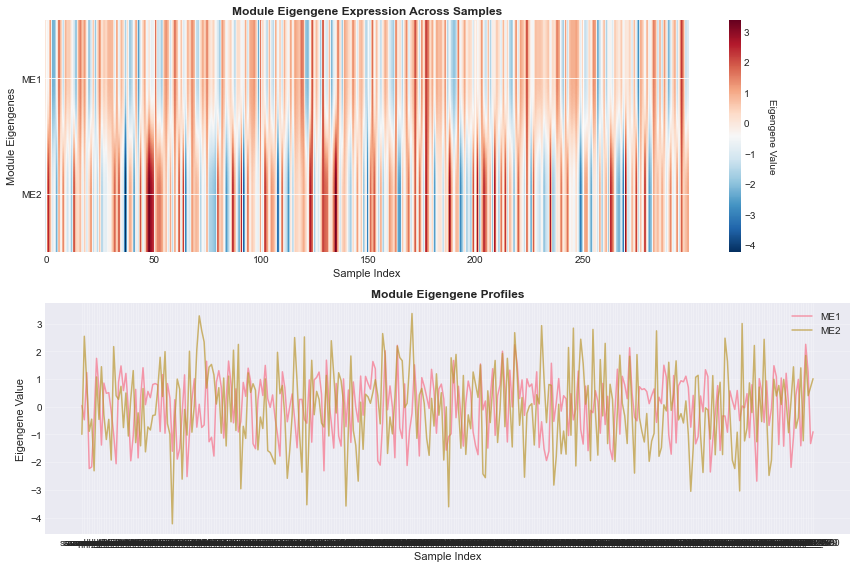


Module eigengene summary statistics:
            ME1       ME2
count  300.0000  300.0000
mean    -0.0000   -0.0000
std      1.0735    1.4480
min     -2.6846   -4.2232
25%     -0.9055   -0.9921
50%      0.2129    0.0441
75%      0.8276    0.9925
max      2.2518    3.3632

✓ STEP 8 COMPLETE: Module eigengenes calculated for 2 modules


In [11]:
print("="*80)
print("STEP 8: CALCULATE MODULE EIGENGENES (MEs)")
print("="*80)

from sklearn.decomposition import PCA

# Dictionary to store module eigengenes
ME_dict = {}

print("\nComputing module eigengenes via PCA...")

# Process each module (excluding grey/module 0)
for mod_num in sorted(module_assignment['ModuleNumber'].unique()):
    if mod_num == 0:
        continue  # Skip grey module
    
    # Get genes in this module
    module_genes = module_assignment[module_assignment['ModuleNumber'] == mod_num]['Gene'].tolist()
    module_color = module_assignment[module_assignment['ModuleNumber'] == mod_num]['ModuleColor'].iloc[0]
    
    print(f"\n  Module {mod_num} ({module_color}):")
    print(f"    Genes: {', '.join(module_genes)}")
    
    # Get expression data for module genes
    module_expr = datExpr_log[module_genes]
    
    if len(module_genes) == 1:
        # If only one gene, use it directly as eigengene
        ME_dict[f'ME{mod_num}'] = module_expr.iloc[:, 0].values
        print(f"    Single gene module - using gene expression directly")
    else:
        # Use PCA to extract first principal component
        pca = PCA(n_components=1)
        pc1 = pca.fit_transform(module_expr).flatten()
        
        # Store PC1 as module eigengene
        ME_dict[f'ME{mod_num}'] = pc1
        
        # Report variance explained
        var_explained = pca.explained_variance_ratio_[0]
        print(f"    PCA variance explained by PC1: {var_explained:.2%}")

# Create Module Eigengene DataFrame
ME_df = pd.DataFrame(ME_dict, index=datExpr_log.index)

print(f"\n✓ Module eigengenes computed")
print(f"\nModule Eigengene matrix shape: {ME_df.shape}")
print(f"  Samples: {ME_df.shape[0]}")
print(f"  Modules: {ME_df.shape[1]}")

# Visualize module eigengenes
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Heatmap of module eigengenes
im = axes[0].imshow(ME_df.T, aspect='auto', cmap='RdBu_r')
axes[0].set_yticks(range(ME_df.shape[1]))
axes[0].set_yticklabels(ME_df.columns)
axes[0].set_xlabel('Sample Index', fontsize=11)
axes[0].set_ylabel('Module Eigengenes', fontsize=11)
axes[0].set_title('Module Eigengene Expression Across Samples', 
                 fontsize=12, fontweight='bold')
cbar = plt.colorbar(im, ax=axes[0])
cbar.set_label('Eigengene Value', rotation=270, labelpad=20)

# Plot 2: Line plots of eigengenes
for col in ME_df.columns:
    axes[1].plot(ME_df[col], label=col, alpha=0.7, linewidth=1.5)
axes[1].set_xlabel('Sample Index', fontsize=11)
axes[1].set_ylabel('Eigengene Value', fontsize=11)
axes[1].set_title('Module Eigengene Profiles', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display summary statistics
print("\nModule eigengene summary statistics:")
print(ME_df.describe().round(4))

print("\n" + "="*80)
print(f"✓ STEP 8 COMPLETE: Module eigengenes calculated for {ME_df.shape[1]} modules")
print("="*80)

---
## Step 9: Merge Similar Modules

**Goal**: Merge modules with highly correlated eigengenes
- Calculate pairwise correlations between module eigengenes
- Cluster eigengenes hierarchically
- Merge modules if correlation > threshold (e.g., 0.75)
- Output: Updated module assignments and merged eigengenes

STEP 9: MERGE SIMILAR MODULES

Merge threshold: correlation > 0.75

Module eigengene correlations:
       ME1    ME2
ME1  1.000 -0.077
ME2 -0.077  1.000


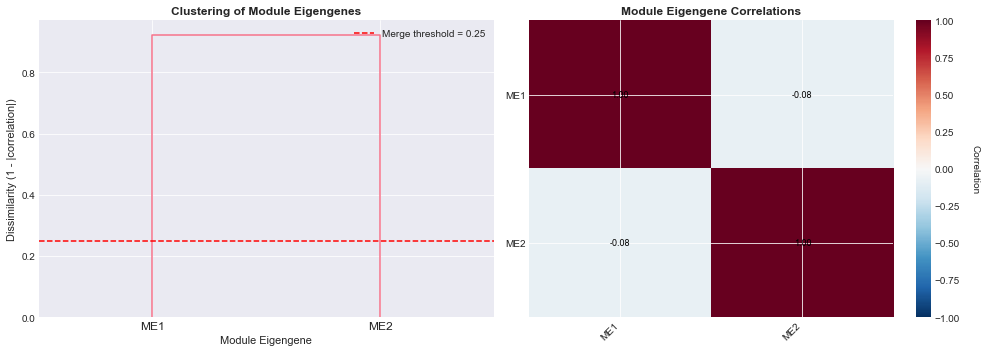


Merge groups identified:
  No modules need merging (all correlations < 0.75)

✓ STEP 9 COMPLETE: Final module count = 2


In [12]:
print("="*80)
print("STEP 9: MERGE SIMILAR MODULES")
print("="*80)

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

# Parameters
merge_threshold = 0.75  # Merge if correlation > 0.75

print(f"\nMerge threshold: correlation > {merge_threshold}")

# Calculate correlations between module eigengenes
ME_corr = ME_df.corr()

print(f"\nModule eigengene correlations:")
print(ME_corr.round(3))

# Convert to dissimilarity (1 - correlation)
ME_diss = 1 - ME_corr.abs()

# Hierarchical clustering of module eigengenes
ME_tree = linkage(squareform(ME_diss, checks=False), method='average')

# Visualize module eigengene clustering
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Dendrogram of module eigengenes
dendro = dendrogram(ME_tree, labels=ME_df.columns.tolist(), ax=ax1)
ax1.set_title('Clustering of Module Eigengenes', fontsize=12, fontweight='bold')
ax1.set_xlabel('Module Eigengene', fontsize=11)
ax1.set_ylabel('Dissimilarity (1 - |correlation|)', fontsize=11)
ax1.axhline(y=1-merge_threshold, color='red', linestyle='--', 
           label=f'Merge threshold = {1-merge_threshold:.2f}')
ax1.legend()

# Heatmap of module correlations
im = ax2.imshow(ME_corr, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax2.set_xticks(range(len(ME_corr.columns)))
ax2.set_yticks(range(len(ME_corr.columns)))
ax2.set_xticklabels(ME_corr.columns, rotation=45, ha='right')
ax2.set_yticklabels(ME_corr.columns)
ax2.set_title('Module Eigengene Correlations', fontsize=12, fontweight='bold')
cbar = plt.colorbar(im, ax=ax2)
cbar.set_label('Correlation', rotation=270, labelpad=20)

# Add correlation values
for i in range(len(ME_corr)):
    for j in range(len(ME_corr)):
        ax2.text(j, i, f'{ME_corr.iloc[i, j]:.2f}',
                ha="center", va="center", color="black", fontsize=9)

plt.tight_layout()
plt.show()

# Determine which modules to merge
# Cut tree at height = 1 - merge_threshold
merge_cut = 1 - merge_threshold
merge_groups = fcluster(ME_tree, t=merge_cut, criterion='distance')

print(f"\nMerge groups identified:")
merge_mapping = {}
for idx, me_name in enumerate(ME_df.columns):
    merge_group = merge_groups[idx]
    if merge_group not in merge_mapping:
        merge_mapping[merge_group] = []
    merge_mapping[merge_group].append(me_name)

# Check if any merging is needed
modules_to_merge = sum(1 for v in merge_mapping.values() if len(v) > 1)

if modules_to_merge > 0:
    print(f"  {modules_to_merge} group(s) of modules will be merged:")
    for group_id, modules in merge_mapping.items():
        if len(modules) > 1:
            print(f"    Group {group_id}: {', '.join(modules)}")
    
    # Merge modules (recalculate eigengenes for merged groups)
    ME_merged_dict = {}
    module_assignment_merged = module_assignment.copy()
    
    for group_id, me_names in merge_mapping.items():
        # Get module numbers from ME names (e.g., 'ME1' -> 1)
        mod_nums = [int(name.replace('ME', '')) for name in me_names]
        
        # Get all genes in these modules
        genes_in_group = module_assignment[
            module_assignment['ModuleNumber'].isin(mod_nums)
        ]['Gene'].tolist()
        
        if len(genes_in_group) > 1:
            # Recalculate eigengene for merged module
            merged_expr = datExpr_log[genes_in_group]
            pca_merged = PCA(n_components=1)
            merged_me = pca_merged.fit_transform(merged_expr).flatten()
        else:
            # Single gene
            merged_me = datExpr_log[genes_in_group[0]].values
        
        # Use first module number as the new merged module ID
        new_mod_num = min(mod_nums)
        ME_merged_dict[f'ME{new_mod_num}'] = merged_me
        
        # Update module assignments - reassign all to first module number
        for mod_num in mod_nums:
            module_assignment_merged.loc[
                module_assignment_merged['ModuleNumber'] == mod_num,
                'ModuleNumber'
            ] = new_mod_num
    
    ME_df_final = pd.DataFrame(ME_merged_dict, index=datExpr_log.index)
    module_assignment_final = module_assignment_merged
    
    print(f"\n✓ Modules merged")
    print(f"  Final number of modules: {len(ME_merged_dict)}")
else:
    print(f"  No modules need merging (all correlations < {merge_threshold})")
    ME_df_final = ME_df.copy()
    module_assignment_final = module_assignment.copy()

print("\n" + "="*80)
print(f"✓ STEP 9 COMPLETE: Final module count = {ME_df_final.shape[1]}")
print("="*80)

---
## Step 10: Compute Gene-Module Relationships

**Goal**: Quantify gene membership in modules and identify hub genes
- **Module Membership (kME)**: Correlation between gene and module eigengene
- **Intramodular Connectivity**: Sum of adjacency with other module genes
- **Hub Genes**: Genes with highest kME and connectivity within modules
- Output: kME matrix and hub gene identification

STEP 10: COMPUTE GENE-MODULE RELATIONSHIPS

Calculating Module Membership (kME)...
  kME = correlation(gene expression, module eigengene)
✓ kME calculated for 10 genes

Calculating intramodular connectivity...
✓ Intramodular connectivity calculated

Identifying hub genes (top genes by kME in each module)...

  Module 1 (turquoise):
    gene_10: kME=0.988, connectivity=0.93
    gene_3: kME=0.977, connectivity=0.93

  Module 2 (blue):
    gene_4: kME=0.958, connectivity=3.61
    gene_9: kME=0.945, connectivity=3.58
    gene_7: kME=0.942, connectivity=3.51


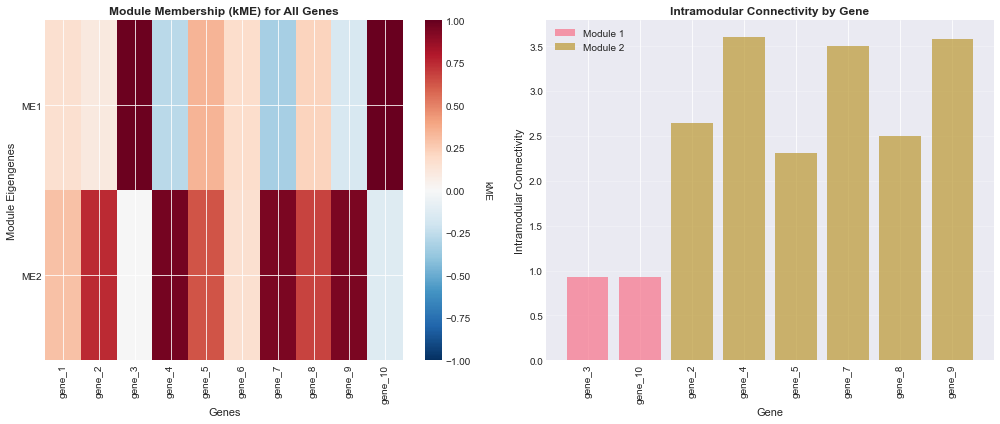


✓ Hub genes identified: 5 total
  Hub genes: gene_10, gene_3, gene_4, gene_9, gene_7

✓ STEP 10 COMPLETE: Gene-module relationships computed


In [13]:
print("="*80)
print("STEP 10: COMPUTE GENE-MODULE RELATIONSHIPS")
print("="*80)

# Calculate Module Membership (kME) for each gene
print("\nCalculating Module Membership (kME)...")
print("  kME = correlation(gene expression, module eigengene)")

kME_data = []

for gene in datExpr_log.columns:
    gene_expr = datExpr_log[gene]
    kME_row = {'Gene': gene}
    
    # Calculate correlation with each module eigengene
    for me_col in ME_df_final.columns:
        corr, pval = stats.pearsonr(gene_expr, ME_df_final[me_col])
        kME_row[f'kME_{me_col}'] = corr
        kME_row[f'pval_{me_col}'] = pval
    
    kME_data.append(kME_row)

kME_df = pd.DataFrame(kME_data)

print(f"✓ kME calculated for {len(kME_df)} genes")

# Add module assignment to kME dataframe
kME_df = kME_df.merge(
    module_assignment_final[['Gene', 'ModuleNumber', 'ModuleColor']],
    on='Gene'
)

# Calculate intramodular connectivity (sum of adjacency with module genes)
print("\nCalculating intramodular connectivity...")

connectivity_data = []

for gene in datExpr_log.columns:
    gene_idx = datExpr_log.columns.tolist().index(gene)
    mod_num = kME_df[kME_df['Gene'] == gene]['ModuleNumber'].iloc[0]
    
    if mod_num == 0:
        # Grey module (unassigned)
        connectivity = 0
    else:
        # Get genes in the same module
        module_genes = module_assignment_final[
            module_assignment_final['ModuleNumber'] == mod_num
        ]['Gene'].tolist()
        module_indices = [datExpr_log.columns.tolist().index(g) for g in module_genes]
        
        # Sum adjacency with module genes (excluding self)
        connectivity = A.iloc[gene_idx, module_indices].sum() - A.iloc[gene_idx, gene_idx]
    
    connectivity_data.append({
        'Gene': gene,
        'IntramodularConnectivity': connectivity
    })

connectivity_df = pd.DataFrame(connectivity_data)
kME_df = kME_df.merge(connectivity_df, on='Gene')

print(f"✓ Intramodular connectivity calculated")

# Identify hub genes (top genes by kME within each module)
print("\nIdentifying hub genes (top genes by kME in each module)...")

hub_genes = []

for mod_num in sorted(module_assignment_final['ModuleNumber'].unique()):
    if mod_num == 0:
        continue  # Skip grey module
    
    # Get genes in this module
    module_genes_df = kME_df[kME_df['ModuleNumber'] == mod_num].copy()
    
    # Get kME for this module
    kme_col = f'kME_ME{mod_num}'
    
    # Sort by kME (descending) and connectivity (descending)
    module_genes_df = module_genes_df.sort_values(
        [kme_col, 'IntramodularConnectivity'],
        ascending=[False, False]
    )
    
    # Top 3 genes or all if fewer
    n_hub = min(3, len(module_genes_df))
    top_genes = module_genes_df.head(n_hub)
    
    color = module_genes_df.iloc[0]['ModuleColor']
    
    print(f"\n  Module {mod_num} ({color}):")
    for idx, row in top_genes.iterrows():
        print(f"    {row['Gene']}: kME={row[kme_col]:.3f}, connectivity={row['IntramodularConnectivity']:.2f}")
    
    hub_genes.extend(top_genes['Gene'].tolist())

# Visualize kME heatmap
kme_cols = [col for col in kME_df.columns if col.startswith('kME_')]
kme_matrix = kME_df[['Gene'] + kme_cols].set_index('Gene')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# kME heatmap
im1 = ax1.imshow(kme_matrix.T, aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1)
ax1.set_yticks(range(len(kme_matrix.columns)))
ax1.set_yticklabels([c.replace('kME_', '') for c in kme_matrix.columns])
ax1.set_xticks(range(len(kme_matrix.index)))
ax1.set_xticklabels(kme_matrix.index, rotation=90)
ax1.set_title('Module Membership (kME) for All Genes', fontsize=12, fontweight='bold')
ax1.set_xlabel('Genes', fontsize=11)
ax1.set_ylabel('Module Eigengenes', fontsize=11)
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('kME', rotation=270, labelpad=20)

# Connectivity by module
for mod_num in sorted(module_assignment_final['ModuleNumber'].unique()):
    if mod_num == 0:
        continue
    module_genes_df = kME_df[kME_df['ModuleNumber'] == mod_num]
    color = module_genes_df.iloc[0]['ModuleColor']
    ax2.bar(
        module_genes_df['Gene'],
        module_genes_df['IntramodularConnectivity'],
        label=f'Module {mod_num}',
        alpha=0.7
    )

ax2.set_xlabel('Gene', fontsize=11)
ax2.set_ylabel('Intramodular Connectivity', fontsize=11)
ax2.set_title('Intramodular Connectivity by Gene', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', rotation=90)
ax2.grid(True, alpha=0.3, axis='y')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\n✓ Hub genes identified: {len(hub_genes)} total")
print(f"  Hub genes: {', '.join(hub_genes)}")

print("\n" + "="*80)
print("✓ STEP 10 COMPLETE: Gene-module relationships computed")
print("="*80)

---
## Step 11: Relate Modules to External Traits

**Goal**: Correlate module eigengenes with phenotypes and clinical traits
- Calculate Pearson correlation between MEs and traits
- Identify biologically relevant modules
- **Traits analyzed**:
  - ASD diagnosis (case/control)
  - Age, Sex, IQ
  - ADOS Score (autism severity)
  - Genetic burden (SNP risk alleles)
- Output: Module-trait association statistics and visualizations

STEP 11: RELATE MODULES TO EXTERNAL TRAITS

Traits being analyzed:
  - ASD diagnosis (0=control, 1=case)
  - Age (years)
  - Sex (0=Female, 1=Male)
  - IQ (intelligence quotient)
  - ADOS_Score (autism severity, available for cases only)

Calculating module-trait correlations...
✓ Module-trait correlations calculated

Module-Trait Correlations:
          ASD    Age    Sex     IQ  ADOS_Score
Module                                        
ME1     0.811  0.025  0.343 -0.322       0.767
ME2    -0.623 -0.024 -0.212  0.205      -0.533

P-values:
             ASD    Age       Sex        IQ ADOS_Score
Module                                                
ME1     1.90e-71  0.663  1.03e-09  1.11e-08   2.51e-59
ME2     1.04e-33  0.675  2.09e-04  3.42e-04   2.17e-23

GENETIC BURDEN ANALYSIS

Genetic burden calculated as sum of risk alleles
  Genetic burden range: 9 to 43
  Mean burden: 24.15

Module-Genetic Burden Correlations:
  ME1: r=0.429, p=0.0000
  ME2: r=-0.371, p=0.0000


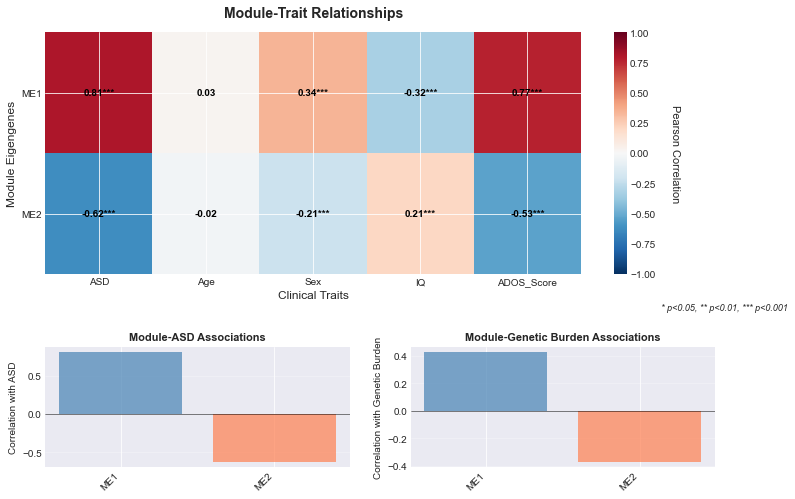


SUMMARY OF SIGNIFICANT MODULE-TRAIT ASSOCIATIONS (p < 0.05)

ASD:
  ME1 (r=0.811, p=0.0000)
  ME2 (r=-0.623, p=0.0000)

Sex:
  ME1 (r=0.343, p=0.0000)
  ME2 (r=-0.212, p=0.0002)

IQ:
  ME1 (r=-0.322, p=0.0000)
  ME2 (r=0.205, p=0.0003)

ADOS_Score:
  ME1 (r=0.767, p=0.0000)
  ME2 (r=-0.533, p=0.0000)

✓ STEP 11 COMPLETE: Module-trait analysis finished

WGCNA ANALYSIS COMPLETE!

Final Results:
  - 10 genes analyzed
  - 2 co-expression modules identified
  - 5 hub genes identified
  - Module-trait correlations computed for 5 clinical traits
  - Module-genetic burden correlations computed

Key outputs saved to: ../data/ASD_dataset/


In [14]:
print("="*80)
print("STEP 11: RELATE MODULES TO EXTERNAL TRAITS")
print("="*80)

# Define traits of interest
traits = covariates_indexed[['ASD', 'Age', 'Sex', 'IQ', 'ADOS_Score']].copy()

print("\nTraits being analyzed:")
print(f"  - ASD diagnosis (0=control, 1=case)")
print(f"  - Age (years)")
print(f"  - Sex (0=Female, 1=Male)")
print(f"  - IQ (intelligence quotient)")
print(f"  - ADOS_Score (autism severity, available for cases only)")

# Calculate module-trait correlations
print("\nCalculating module-trait correlations...")

module_trait_corr_data = []
module_trait_pval_data = []

for module in ME_df_final.columns:
    corr_row = {'Module': module}
    pval_row = {'Module': module}
    
    for trait in traits.columns:
        # Handle NaN values in traits (e.g., ADOS_Score for controls)
        valid_idx = ~traits[trait].isna()
        
        if valid_idx.sum() > 0:
            corr, pval = stats.pearsonr(
                ME_df_final.loc[valid_idx, module],
                traits.loc[valid_idx, trait]
            )
            corr_row[trait] = corr
            pval_row[trait] = pval
        else:
            corr_row[trait] = np.nan
            pval_row[trait] = np.nan
    
    module_trait_corr_data.append(corr_row)
    module_trait_pval_data.append(pval_row)

# Create DataFrames
module_trait_corr = pd.DataFrame(module_trait_corr_data).set_index('Module')
module_trait_pval = pd.DataFrame(module_trait_pval_data).set_index('Module')

print("✓ Module-trait correlations calculated")

print("\nModule-Trait Correlations:")
print(module_trait_corr.round(3))

print("\nP-values:")
pval_formatted = module_trait_pval.copy()
for col in pval_formatted.columns:
    pval_formatted[col] = pval_formatted[col].apply(
        lambda x: f"{x:.2e}" if pd.notna(x) and x < 0.001 else f"{x:.3f}" if pd.notna(x) else "NaN"
    )
print(pval_formatted)

# Calculate genetic burden (sum of risk alleles)
print("\n" + "="*60)
print("GENETIC BURDEN ANALYSIS")
print("="*60)

genetic_burden = genotypes_indexed.sum(axis=1)

print(f"\nGenetic burden calculated as sum of risk alleles")
print(f"  Genetic burden range: {genetic_burden.min()} to {genetic_burden.max()}")
print(f"  Mean burden: {genetic_burden.mean():.2f}")

# Correlate modules with genetic burden
print("\nModule-Genetic Burden Correlations:")
genetic_corr_data = []

for module in ME_df_final.columns:
    corr, pval = stats.pearsonr(ME_df_final[module], genetic_burden)
    genetic_corr_data.append({
        'Module': module,
        'Correlation': corr,
        'P-value': pval
    })
    print(f"  {module}: r={corr:.3f}, p={pval:.4f}")

genetic_corr_df = pd.DataFrame(genetic_corr_data)

# VISUALIZATIONS
# Plot 1: Module-Trait Heatmap
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[2, 1], hspace=0.4)

# Main heatmap
ax1 = fig.add_subplot(gs[0, :])
im = ax1.imshow(module_trait_corr.astype(float), cmap='RdBu_r', 
               vmin=-1, vmax=1, aspect='auto')
ax1.set_yticks(range(len(module_trait_corr.index)))
ax1.set_xticks(range(len(module_trait_corr.columns)))
ax1.set_yticklabels(module_trait_corr.index)
ax1.set_xticklabels(module_trait_corr.columns)
ax1.set_title('Module-Trait Relationships', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Clinical Traits', fontsize=12)
ax1.set_ylabel('Module Eigengenes', fontsize=12)

# Add correlation values and significance stars
for i in range(len(module_trait_corr.index)):
    for j in range(len(module_trait_corr.columns)):
        corr_val = module_trait_corr.iloc[i, j]
        pval = module_trait_pval.iloc[i, j]
        
        # Add significance stars
        if pd.notna(pval):
            if pval < 0.001:
                sig = '***'
            elif pval < 0.01:
                sig = '**'
            elif pval < 0.05:
                sig = '*'
            else:
                sig = ''
            
            text = f'{corr_val:.2f}{sig}'
            ax1.text(j, i, text, ha="center", va="center", 
                    color="black", fontsize=10, fontweight='bold')

cbar = plt.colorbar(im, ax=ax1)
cbar.set_label('Pearson Correlation', rotation=270, labelpad=25, fontsize=11)

# Add significance legend
ax1.text(1.15, -0.15, '* p<0.05, ** p<0.01, *** p<0.001', 
        transform=ax1.transAxes, fontsize=9, style='italic')

# Plot 2: ASD correlation bar plot
ax2 = fig.add_subplot(gs[1, 0])
asd_corrs = module_trait_corr['ASD'].values
colors_list = ['steelblue' if c > 0 else 'coral' for c in asd_corrs]
ax2.bar(range(len(asd_corrs)), asd_corrs, color=colors_list, alpha=0.7)
ax2.set_xticks(range(len(module_trait_corr.index)))
ax2.set_xticklabels(module_trait_corr.index, rotation=45, ha='right')
ax2.set_ylabel('Correlation with ASD', fontsize=10)
ax2.set_title('Module-ASD Associations', fontsize=11, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Genetic burden correlation bar plot
ax3 = fig.add_subplot(gs[1, 1])
gen_corrs = genetic_corr_df['Correlation'].values
colors_list = ['steelblue' if c > 0 else 'coral' for c in gen_corrs]
ax3.bar(range(len(gen_corrs)), gen_corrs, color=colors_list, alpha=0.7)
ax3.set_xticks(range(len(genetic_corr_df)))
ax3.set_xticklabels(genetic_corr_df['Module'], rotation=45, ha='right')
ax3.set_ylabel('Correlation with Genetic Burden', fontsize=10)
ax3.set_title('Module-Genetic Burden Associations', fontsize=11, fontweight='bold')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/ASD_dataset/WGCNA_module_trait_relationships_complete.png', 
           dpi=300, bbox_inches='tight')
plt.show()

# Summary of significant associations
print("\n" + "="*80)
print("SUMMARY OF SIGNIFICANT MODULE-TRAIT ASSOCIATIONS (p < 0.05)")
print("="*80)

significant_found = False

for trait in module_trait_corr.columns:
    sig_modules = []
    for module in module_trait_corr.index:
        corr = module_trait_corr.loc[module, trait]
        pval = module_trait_pval.loc[module, trait]
        
        if pd.notna(pval) and pval < 0.05:
            sig_modules.append(f"{module} (r={corr:.3f}, p={pval:.4f})")
            significant_found = True
    
    if sig_modules:
        print(f"\n{trait}:")
        for mod_str in sig_modules:
            print(f"  {mod_str}")

if not significant_found:
    print("\n  No significant associations found at p < 0.05")
    print("  (This is common with small datasets - consider as exploratory)")

print("\n" + "="*80)
print("✓ STEP 11 COMPLETE: Module-trait analysis finished")
print("="*80)

print("\n" + "="*80)
print("WGCNA ANALYSIS COMPLETE!")
print("="*80)
print(f"\nFinal Results:")
print(f"  - {len(datExpr_log.columns)} genes analyzed")
print(f"  - {ME_df_final.shape[1]} co-expression modules identified")
print(f"  - {len(hub_genes)} hub genes identified")
print(f"  - Module-trait correlations computed for {len(traits.columns)} clinical traits")
print(f"  - Module-genetic burden correlations computed")
print(f"\nKey outputs saved to: ../data/ASD_dataset/")
print("="*80)

# Run original WGCNA

In [15]:
"""
WGCNA Analysis using R implementation via Docker
This module provides a Python wrapper for running WGCNA analysis
using the R WGCNA package inside a Docker container.
"""

import pandas as pd
import numpy as np
import subprocess
import tempfile
import os
import shutil
from pathlib import Path


n_modules=4
docker_image="kkhaichau/weighted_networks"
"""
Run WGCNA analysis using R implementation in Docker container.

Parameters:
-----------
expression_indexed : pd.DataFrame
    Expression data with samples as rows and genes as columns.
    Index should be sample IDs, columns should be gene names.
n_modules : int, default=4
    Number of co-expression modules to identify.
docker_image : str, default="kkhaichau/weighted_networks"
    Docker image containing R and WGCNA package.

Returns:
--------
module_assignment : pd.DataFrame
    DataFrame with columns ['Gene', 'Module'] mapping genes to modules.
me_df : pd.DataFrame
    DataFrame with module eigengenes (samples x modules).
    Columns are named 'ME0', 'ME1', etc.
"""

print("Performing WGCNA - Weighted Co-expression Network Analysis\n")
print("="*80)

# Create temporary directory for data exchange
temp_dir = tempfile.mkdtemp(prefix="wgcna_")

try:
    # Define file paths
    input_csv = os.path.join(temp_dir, "expression_data.csv")
    module_csv = os.path.join(temp_dir, "module_assignment.csv")
    eigengene_csv = os.path.join(temp_dir, "module_eigengenes.csv")
    r_script = os.path.join(temp_dir, "wgcna_analysis.R")

    # Copy R script to temp directory
    script_source = os.path.join("../wgcna_analysis.R")
    shutil.copy(script_source, r_script)

    # Save expression data to CSV
    # Ensure index name is set for proper CSV export
    if expression_indexed.index.name is None:
        expression_indexed.index.name = "SampleID"
    expression_indexed.to_csv(input_csv)

    # Build docker command
    docker_cmd = [
        "docker", "run", "--rm",
        "--platform", "linux/amd64",  # Specify platform for compatibility
        "-v", f"{temp_dir}:/data",  # Mount temp directory
        docker_image,
        "Rscript", "/data/wgcna_analysis.R",
        "/data/expression_data.csv",
        "/data/module_assignment.csv",
        "/data/module_eigengenes.csv",
        str(n_modules)
    ]

    # Run Docker container
    print(f"Running WGCNA analysis in Docker container...\n")
    result = subprocess.run(
        docker_cmd,
        capture_output=True,
        text=True,
        check=True
    )

    # Print R script output
    print(result.stdout)

    if result.stderr:
        # Print warnings/messages from R (not necessarily errors)
        print("R Messages:", result.stderr)

    # Read results
    module_assignment = pd.read_csv(module_csv)
    eigengenes_raw = pd.read_csv(eigengene_csv)

    # Process eigengenes - set SampleID as index and remove the column
    me_df = eigengenes_raw.set_index('SampleID')

    # Ensure index matches original expression data index
    me_df.index = expression_indexed.index

    # Validate results
    if len(module_assignment) != len(expression_indexed.columns):
        raise ValueError(
            f"Module assignment count ({len(module_assignment)}) "
            f"doesn't match number of genes ({len(expression_indexed.columns)})"
        )

    if me_df.shape[0] != expression_indexed.shape[0]:
        raise ValueError(
            f"Module eigengene samples ({me_df.shape[0]}) "
            f"doesn't match expression samples ({expression_indexed.shape[0]})"
        )

#     return module_assignment, me_df

except subprocess.CalledProcessError as e:
    print(f"Error running Docker container:")
    print(f"Return code: {e.returncode}")
    print(f"STDOUT: {e.stdout}")
    print(f"STDERR: {e.stderr}")
    raise

finally:
    # Clean up temporary directory
    shutil.rmtree(temp_dir, ignore_errors=True)


Performing WGCNA-like Co-expression Network Analysis

Running WGCNA analysis in Docker container...

*
*  Package WGCNA 1.63 loaded.
*
*    Important note: It appears that your system supports multi-threading,
*    but it is not enabled within WGCNA in R. 
*    To allow multi-threading within WGCNA with all available cores, use 
*
*          allowWGCNAThreads()
*
*    within R. Use disableWGCNAThreads() to disable threading if necessary.
*    Alternatively, set the following environment variable on your system:
*
*          ALLOW_WGCNA_THREADS=<number_of_processors>
*
*    for example 
*
*          ALLOW_WGCNA_THREADS=5
*
*    To set the environment variable in linux bash shell, type 
*
*           export ALLOW_WGCNA_THREADS=5
*
*     before running R. Other operating systems or shells will
*     have a similar command to achieve the same aim.
*


Allowing multi-threading with up to 5 threads.
Performing WGCNA-like Co-expression Network Analysis

Loaded expression data: 300 samples x 1

In [16]:
me_df

,ME0,ME1,ME2,ME3
sample,,,,
sample_1,0.063365,-0.044246,-0.013674,0.057695
sample_2,0.114630,0.120750,-0.035715,0.032574
sample_3,0.012099,0.025344,0.069821,-0.042790
sample_4,-0.039167,-0.042957,-0.083667,0.007453
sample_5,-0.039167,-0.027502,-0.082489,-0.042790
...,...,...,...,...
sample_296,-0.028914,-0.049100,0.000210,-0.042790
sample_297,0.083871,0.077523,0.195771,0.107937
sample_298,0.053111,0.020114,0.072659,-0.017669


In [17]:
module_assignment

,Gene,Module
0,gene_1,0
1,gene_2,1
2,gene_3,2
3,gene_4,1
4,gene_5,1
5,gene_6,3
6,gene_7,1
7,gene_8,1
8,gene_9,1
9,gene_10,2



Calculating Module-Trait Relationships

Module-Trait Correlations:
       ASD    Age    Sex     IQ  ADOS_Score
ME0 -0.062 -0.046 -0.114  0.021      -0.032
ME1 -0.612 -0.033 -0.201  0.197      -0.533
ME2  0.715  0.027  0.320 -0.284       0.689
ME3  0.044 -0.000  0.022 -0.086       0.043

P-values:
          ASD    Age       Sex        IQ ADOS_Score
ME0     0.288  0.431     0.048     0.718      0.583
ME1  2.85e-32  0.564  4.67e-04  6.00e-04   2.04e-23
ME2  3.78e-48  0.636  1.39e-08  5.55e-07   1.74e-43
ME3     0.447  0.994     0.699     0.139      0.457


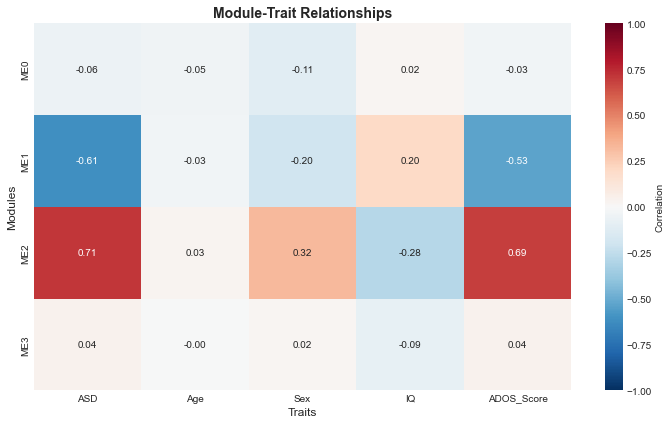


Module-Genetic Burden Correlations:
  ME0: r=-0.099, p=0.0863
  ME1: r=-0.358, p=0.0000
  ME2: r=0.394, p=0.0000
  ME3: r=-0.078, p=0.1802

✓ WGCNA analysis complete


In [19]:
# Calculate module-trait correlations
print("\nCalculating Module-Trait Relationships\n")
print("="*80)

# Define traits of interest
traits = covariates_indexed[['ASD', 'Age', 'Sex', 'IQ', 'ADOS_Score']].copy()

# Calculate correlations and p-values
module_trait_corr_data = []
module_trait_pval_data = []

for module in me_df.columns:
    corr_row = {}
    pval_row = {}
    for trait in traits.columns:
        # Handle NaN in ADOS_Score (controls have 0, not NaN)
        valid_idx = ~traits[trait].isna()
        if valid_idx.sum() > 0:
            corr, pval = stats.pearsonr(me_df.loc[valid_idx, module], 
                                       traits.loc[valid_idx, trait])
            corr_row[trait] = corr
            pval_row[trait] = pval
        else:
            corr_row[trait] = np.nan
            pval_row[trait] = np.nan
    
    module_trait_corr_data.append(corr_row)
    module_trait_pval_data.append(pval_row)

# Create DataFrames
module_trait_corr = pd.DataFrame(module_trait_corr_data, index=me_df.columns)
module_trait_pval = pd.DataFrame(module_trait_pval_data, index=me_df.columns)

print("Module-Trait Correlations:")
print(module_trait_corr.round(3))
print("\nP-values:")
print(module_trait_pval.applymap(lambda x: f"{x:.2e}" if x < 0.001 else f"{x:.3f}"))

# Visualize module-trait relationships
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(module_trait_corr.astype(float), 
            annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Correlation'},
            ax=ax, vmin=-1, vmax=1)
ax.set_title('Module-Trait Relationships', fontsize=14, fontweight='bold')
ax.set_xlabel('Traits', fontsize=12)
ax.set_ylabel('Modules', fontsize=12)
plt.tight_layout()
plt.savefig('../data/ASD_dataset/Phase3_WGCNA_module_trait_relationships.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate genetic burden scores (sum of risk alleles for each sample)
# Use top ASD-associated SNPs
genetic_burden = genotypes_indexed.sum(axis=1)  # TODO: Validate if this make sense!

# Correlate modules with genetic burden
print("\n" + "="*80)
print("Module-Genetic Burden Correlations:")
for module in me_df.columns:
    corr, pval = stats.pearsonr(me_df[module], genetic_burden)
    print(f"  {module}: r={corr:.3f}, p={pval:.4f}")

print("\n✓ WGCNA analysis complete")